In [26]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
#import seaborn as sns

In [8]:
from random import random
from tqdm.notebook import tqdm

In [ ]:
import time
import multiprocess as mp

### Read data

In [22]:
def read_data(indices = None ,chromosome = None, dataframe = False): 
    df_ref = pd.read_csv('./Data/glioblastoma_BT_S2/ref.csv', index_col = 0)
    df_alt = pd.read_csv('./Data/glioblastoma_BT_S2/alt.csv', index_col = 0)
    
    df_ref['chromosome'] = [locus.split('_')[0] for locus in df_ref.index]
    df_ref['locus'] = [locus.split('_')[1] for locus in df_ref.index]
    df_ref = df_ref.set_index(['chromosome', 'locus']) # use multi-index

    df_alt['chromosome'] = [locus.split('_')[0] for locus in df_alt.index]
    df_alt['locus'] = [locus.split('_')[1] for locus in df_alt.index]
    df_alt = df_alt.set_index(['chromosome', 'locus'])
    
    if indices is not None: 
        df_ref = df_ref.iloc[indices,:]
        df_alt = df_alt.iloc[indices,:]
    
    if chromosome is not None: 
        df_ref = df_ref.loc[chromosome,:]
        df_alt = df_alt.loc[chromosome,:]
    
    if dataframe: 
        return df_ref, df_alt
    
    ref = df_ref.to_numpy(dtype = float)
    alt = df_alt.to_numpy(dtype = float)
    #coverage = ref.flatten() + alt.flatten()
    
    return ref, alt

### Mutation detection

In [ ]:
from mutation_detection import *
from LOH_detection import *

In [ ]:
ref.shape

In [ ]:
(1 - 1/(2*1168 - 2)**2) ** 16153

In [ ]:
get_composition_priors(10, genotype_freq = {'R': 1/3, 'H': 1/3, 'A': 1/3}, mutation_rate = 0.25)

In [ ]:
start_time = time.time()
posteriors = get_posteriors(ref, alt, n_threads = 6)
print('Runtime:', (time.time() - start_time) / 60, 'min')
pd.DataFrame(posteriors, columns = ['R', 'H', 'A', 'RH', 'HA'], index = df_ref.index).to_csv('./posteriors.csv')

In [24]:
df_posteriors = pd.read_csv('./posteriors.csv', index_col = (0,1))
posteriors = df_posteriors.to_numpy()

In [27]:
mutated_idx, mut_type_idx = np.where(posteriors[:,3:] > 1 - 1 / posteriors.shape[0])
n_mutated = mutated_idx.size
homos = [['R', 'A'][i] for i in mut_type_idx]

In [ ]:
corr_posteriors = get_corr_posteriors(ref[mutated_idx,:], alt[mutated_idx,:], homos, corr_prior = 1/2) 

In [ ]:
pd.DataFrame(data = {'correlation posterior': np.concatenate((corr_posteriors, [0])), 'mutation type': ['H' + h for h in homos]}, 
             index = df_posteriors.index[mutated_idx]).to_csv('./corr_posteriors.csv')

### Data generator

In [1]:
from data_generator import *

In [2]:
dg = DataGenerator(50, 200)

In [3]:
ref, alt, gt1, gt2 = dg.generate_reads()

  0%|          | 0/50 [00:00<?, ?it/s]

### Tree inference with generated data

In [9]:
from tree_inference import TreeOptimizer
from mutation_detection import cell_locus_likelihoods
from utilities import path_len_dist

In [10]:
likelihoods1, likelihoods2 = cell_locus_likelihoods(ref, alt, gt1, gt2)

#### True tree

In [11]:
import matplotlib.pyplot as plt

In [12]:
optz = TreeOptimizer()
optz.fit(likelihoods2, likelihoods1, reversible = True)
optz.ct = dg.tree.copy()
optz.update_ct()

In [13]:
print('distance to real tree:', path_len_dist(optz.ct, dg.tree))

distance to real tree: 0


In [14]:
optz.ct_joint

-12100.167249

In [15]:
optz.mt.fit_structure(optz.ct)
optz.mt_L[:,optz.mt.root.ID] = np.sum(optz.likelihoods1, axis = 1)
optz.update_mt()

In [16]:
optz.mt_joint

-12100.167249

#### All mutations reversible

In [17]:
optz = TreeOptimizer()
optz.fit(likelihoods2, likelihoods1, reversible = True)
print('distance to real tree:', path_len_dist(optz.ct, dg.tree))

distance to real tree: 4021


In [18]:
history, space_history = optz.optimize()

[Cell Tree Space] convergence after 2373 steps and 135 move(s).
[Mutation Tree Space] convergence after 3501 steps and 4 move(s).
[Cell Tree Space] convergence after 469 steps and 1 move(s).
[Mutation Tree Space] convergence after 4193 steps and 2 move(s).
[Cell Tree Space] convergence after 250 steps and 0 move(s).
[Mutation Tree Space] convergence after 2000 steps and 0 move(s).


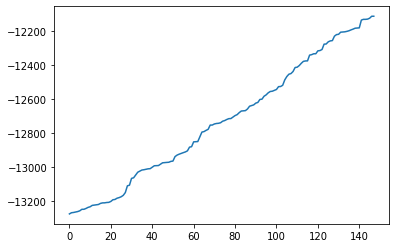

In [19]:
plt.plot(history)

In [20]:
print('distance to real tree:', path_len_dist(optz.ct, dg.tree))
print('cell tree joint likelihood:', optz.ct_joint)
print('mutation tree joint likelihood:', optz.mt_joint)

distance to real tree: 1452
cell tree joint likelihood: -12112.908482
mutation tree joint likelihood: -12112.908482


#### No mutation reversible

In [21]:
optz = TreeOptimizer()
optz.fit(likelihoods1, likelihoods2, reversible = False)
print('distance to real tree:', path_len_dist(optz.ct, dg.tree))

distance to real tree: 5038


In [22]:
history, space_history = optz.optimize()

[Cell Tree Space] convergence after 2280 steps and 107 move(s).
[Mutation Tree Space] convergence after 9214 steps and 12 move(s).
[Cell Tree Space] convergence after 416 steps and 2 move(s).
[Mutation Tree Space] convergence after 2000 steps and 0 move(s).
[Cell Tree Space] convergence after 250 steps and 0 move(s).


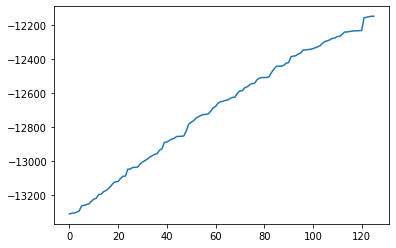

In [23]:
plt.plot(history)

In [24]:
print('distance to real tree:', path_len_dist(optz.ct, dg.tree))
print('cell tree joint likelihood:', optz.ct_joint)
print('mutation tree joint likelihood:', optz.mt_joint)

distance to real tree: 1570
cell tree joint likelihood: -12150.366841
mutation tree joint likelihood: -12150.366841


#### Test settings and make boxplot

In [28]:
def test_settings(settings, ref_tree, n_tests = 10): 
    n_settings = len(settings)
    final_likelihoods = np.empty((n_tests, n_settings))
    final_dist = np.empty((n_tests, n_settings))
    for i in tqdm(range(n_tests)): 
        for j in range(n_settings): 
            likelihoods1 = settings[j]['likelihoods1']
            likelihoods2 = settings[j]['likelihoods2']
            reversible = settings[j]['reversible']
        
            optz = TreeOptimizer()
            optz.fit(likelihoods1, likelihoods2, reversible = reversible)
            history, space_history = optz.optimize(print_space_result = False)
            final_likelihoods[i,j] = history[-1]
            final_dist[i,j] = path_len_dist(optz.ct, ref_tree)
    
    #print(final_likelihoods)
    #print(final_dist)
    
    plt.figure()
    plt.boxplot(final_likelihoods)
    plt.show()
    
    plt.figure()
    plt.boxplot(final_dist)
    plt.show()

In [29]:
settings = [
    {'likelihoods1': likelihoods1, 'likelihoods2': likelihoods2, 'reversible': True}, 
    {'likelihoods1': likelihoods1, 'likelihoods2': likelihoods2, 'reversible': False}, 
    {'likelihoods1': likelihoods2, 'likelihoods2': likelihoods1, 'reversible': True}, 
    {'likelihoods1': likelihoods2, 'likelihoods2': likelihoods1, 'reversible': False}
]

  0%|          | 0/10 [00:00<?, ?it/s]

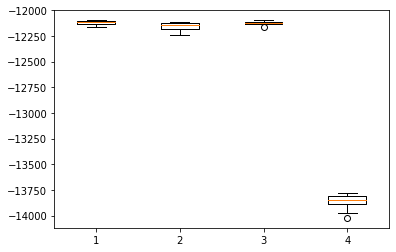

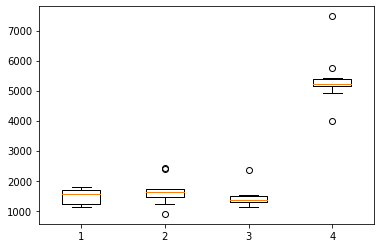

In [30]:
test_settings(settings, dg.tree, n_tests = 10)

### Apply to data, without LOH

### Apply to data, with LOH